# Modeling a single input model

In [53]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import tensorflow as tf
import seaborn as sns
import pickle
import sys

from collections import Counter
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
from keras.callbacks import CSVLogger, LambdaCallback

from model_helper import train_test_split_custom, weighted_bce
from model_helper import accuracy_on_one, accuracy_on_zero
from model_helper import precision_on_1, print_layer_trainable


%matplotlib inline
print(tf.__version__)

2.0.0


# Set Parameters and directories to save models

## Parameters

In [8]:
model_id = 'ALL_FEATURES'
number_of_images = 'all'
EPOCHS = 20
neurons_per_dense = 1024
dense_layers = 2
open_layers = 2
penalty_weight = 10
csv = '../1_cleaning/metadata_cleaned_500.csv' 

In [9]:
BATCH_SIZE = 64 # Choose the batch size before each weight update
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunk of 1024 observations

## Directories

### File naming conventions
Files should be saved in the following convention, which is outlined in the readme file
model#_sample_size#_epoch#_dense#_trainable_layers_loss_function

In [10]:
# Create the name of the model
name_of_model = 'model_' + model_id + \
                '_sample_size_' + str(number_of_images) + \
                '_epoch_' + str(EPOCHS) + \
                '_dense_' + str(dense_layers) + \
                '_neurons_' + str(neurons_per_dense) + \
                '_losswbc_' + \
                '_num_open_layers_' + str(open_layers) + \
                '_penalty_weight_' + str(penalty_weight)

# Send everything to the efs
base_path = '/home/ubuntu/efs/models/'
    
# Directories for checkpoint
checkpoint_path = base_path + 'Checkpoints/' + name_of_model + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# For training history
csv_logger = CSVLogger(base_path + 'Training_history/' + name_of_model + "_history_log.csv", append=True)
training_history_path = base_path + 'Training_history/' + name_of_model + '.pickle'

# For model saving once training has ended
saved_model_path = base_path + 'Saved_models/' + name_of_model + '.h5'

# Model set-up

## Train-test split

In [11]:
# Test train split, plus the features that are used to binarize the data
X_train, X_val, _, _, y_train_bin, y_val_bin, features = \
        train_test_split_custom(number_of_images, csv, multiple_input=False)

In [12]:
y_val_bin.shape

(6671, 184)

## Load the VGG19 pretrained network 

In [13]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [14]:
transfer_layer = vgg.get_layer('block5_pool')

# cutting of the end of the model before the dense layers
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

# freeze VGG
conv_model.trainable = False if open_layers < 1 else True

In [15]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Set the number of trainable layers

In [16]:
for layer in conv_model.layers[:-(open_layers+1):]:
    layer.trainable =  False

In [17]:
for layer in conv_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True


In [47]:
num_label = y_train_bin.shape[1]

def create_model(number_of_dense):
    # Start a new Keras Sequential model.
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(conv_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    for layer in range(number_of_dense):
        
        model.add(Dense(neurons_per_dense, activation='relu'))

        model.add(Dropout(0.2))

    model.add(Dense(num_label, activation='sigmoid'))
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model

In [48]:
new_model = create_model(dense_layers)

In [49]:
print_layer_trainable(new_model)

True:	model
True:	flatten_7
True:	dense_21
True:	dropout_14
True:	dense_22
True:	dropout_15
True:	dense_23


In [50]:
new_model.trainable

True

In [51]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 184)              

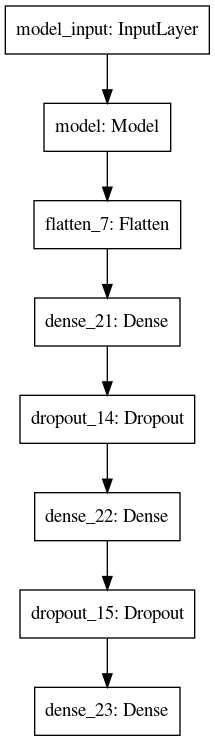

In [52]:
tf.keras.utils.plot_model(
    new_model,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)


## Create a callback checkpoint 

In [42]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Load old weights?

In [43]:
# Loads the weights from the checkpoint path above
# new_model.load_weights(checkpoint_path)

## Create the datasets (incl. image pre-processing, resizing, putting into batches)

In [44]:
# create the datasets
# new_model.load_weights(checkpoint_path)
train_ds = create_dataset(X_train, y_train_bin, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
val_ds = create_dataset(X_val, y_val_bin, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [45]:
y_val_bin.shape

(6671, 709)

# Start Training

## Train the model

In [7]:
'''
import json

file = os.path.join(base_path, 'Training_history/', "sanity_check_callback_log.json")
json_log = open(file, mode='wt', buffering=1)

sanity_check_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'loss': logs}) + '\n'),
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'loss': logs}) + '\n'))
'''

'\nimport json\n\nfile = os.path.join(base_path, \'Training_history/\', "sanity_check_callback_log.json")\njson_log = open(file, mode=\'wt\', buffering=1)\n\nsanity_check_callback = LambdaCallback(\n    on_epoch_begin=lambda epoch, logs: json_log.write(\n        json.dumps({\'epoch\': epoch, \'loss\': logs}) + \'\n\'),\n    on_epoch_end=lambda epoch, logs: json_log.write(\n        json.dumps({\'epoch\': epoch, \'loss\': logs}) + \'\n\'))\n'

In [ ]:
%%time

# Fit the new model and start training
history = new_model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin),
                    callbacks=[cp_callback,
                               csv_logger,
                               #sanity_check_callback,
                              ])

#json_log.close()

Epoch 1/20
      1/Unknown - 2s 2s/step - loss: 0.8936 - accuracy_on_one: 0.4743 - accuracy_on_zero: 0.5012 - precision_on_1: 0.0204

## Save history and model

In [ ]:
# Save the training history

pickle.dump(history.history, open(training_history_path, 'wb'))

# Save the model
new_model.save(saved_model_path)